In [67]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm

In [68]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [69]:
FILE_PATH = "data/generated_data.csv"

df = pd.read_csv(FILE_PATH, header=None)
data = df.values

x = data[:, :3]
y = np.expand_dims(a=data[:, 3], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=27,
                                                    shuffle=True)

x_scaler = StandardScaler().fit(x_train)
y_scaler = StandardScaler().fit(y_train)

# Convert to tensors and normalize to standard normal distribution
x_train = torch.tensor(x_scaler.transform(x_train), dtype=torch.float32).to(device)
x_test  = torch.tensor(x_scaler.transform(x_test), dtype=torch.float32).to(device)
y_train = torch.tensor(y_scaler.transform(y_train), dtype=torch.float32).to(device)
y_test  = torch.tensor(y_scaler.transform(y_test), dtype=torch.float32).to(device)

# Send data to target device
x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

# Batchify
train_dataloader = DataLoader(train_ds,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(test_ds,
                             batch_size=32,
                             shuffle=True)

In [70]:
class Phase1Model(nn.Module):
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int, 
                 output_shape: int):
        super().__init__()
        self.regression_block = nn.Sequential(
            nn.Linear(in_features=input_shape, 
                      out_features=hidden_units),
            nn.GELU(),
            nn.Linear(in_features=hidden_units, 
                      out_features=hidden_units),
            nn.GELU(),
            nn.Linear(in_features=hidden_units, 
                      out_features=hidden_units),
            nn.GELU(),
            nn.Linear(in_features=hidden_units, 
                      out_features=output_shape)
        )

    def forward(self, x):
        return(self.regression_block(x))

In [71]:
model = Phase1Model(3, 1024, 1).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)
loss_fn = nn.MSELoss()
epochs = 2500
results = {"train_loss" : [],
           "test_loss" : []}

In [ ]:
for epoch in tqdm(range(epochs)):

    # ========== TRAINING ==========

    model.train()
    total_train_loss = 0

    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        
        # 1. Forward pass
        y_preds = model(x)

        # 2. Calculate loss
        loss = loss_fn(y_preds, y)
        total_train_loss += loss.item()

        # 3. Optimizer zero grad (zero the gradients)
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step (gradient descent)
        optimizer.step()
    
    total_train_loss = total_train_loss/len(train_dataloader)

    # ========== TESTING/EVAL ==========
    
    model.eval()
    total_test_loss = 0

    with torch.inference_mode():
        for batch, (x, y) in enumerate(test_dataloader):
                # 1. Forward pass
                y_test_preds = model(x)

                # 2. Calculate loss
                test_loss = loss_fn(y_test_preds, y)
                total_test_loss += test_loss.item()

    total_test_loss = total_test_loss/len(test_dataloader)
    
    # Append to results
    results["train_loss"].append(total_train_loss)
    results["test_loss"].append(total_test_loss)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.7f} | Test Loss: {test_loss:.7f}")

  0%|          | 3/2500 [00:00<04:13,  9.86it/s]

Epoch: 0 | Train Loss: 0.6318064 | Test Loss: 4.3318229


  4%|▍         | 103/2500 [00:07<02:54, 13.77it/s]

Epoch: 100 | Train Loss: 0.0003151 | Test Loss: 0.0008036


  8%|▊         | 203/2500 [00:14<02:28, 15.45it/s]

Epoch: 200 | Train Loss: 0.0003356 | Test Loss: 0.0000119


 12%|█▏        | 303/2500 [00:21<02:40, 13.68it/s]

Epoch: 300 | Train Loss: 0.0000078 | Test Loss: 0.0000189


 16%|█▌        | 403/2500 [00:27<02:44, 12.71it/s]

Epoch: 400 | Train Loss: 0.0000265 | Test Loss: 0.0001461


 20%|██        | 503/2500 [00:34<02:02, 16.35it/s]

Epoch: 500 | Train Loss: 0.0000331 | Test Loss: 0.0001298


 24%|██▍       | 603/2500 [00:41<02:26, 12.91it/s]

Epoch: 600 | Train Loss: 0.0000129 | Test Loss: 0.0012977


 28%|██▊       | 703/2500 [00:47<01:45, 17.11it/s]

Epoch: 700 | Train Loss: 0.0000183 | Test Loss: 0.0000073


 32%|███▏      | 803/2500 [00:54<01:56, 14.57it/s]

Epoch: 800 | Train Loss: 0.0000360 | Test Loss: 0.0000450


 36%|███▌      | 903/2500 [01:01<01:39, 16.00it/s]

Epoch: 900 | Train Loss: 0.0000127 | Test Loss: 0.0000181


 40%|████      | 1002/2500 [01:07<01:36, 15.54it/s]

Epoch: 1000 | Train Loss: 0.0000083 | Test Loss: 0.0000048


 44%|████▍     | 1104/2500 [01:14<01:25, 16.31it/s]

Epoch: 1100 | Train Loss: 0.0000135 | Test Loss: 0.0000397


 48%|████▊     | 1202/2500 [01:21<01:26, 15.00it/s]

Epoch: 1200 | Train Loss: 0.0001265 | Test Loss: 0.0001005


 52%|█████▏    | 1302/2500 [01:27<01:16, 15.73it/s]

Epoch: 1300 | Train Loss: 0.0000088 | Test Loss: 0.0000104


 56%|█████▌    | 1402/2500 [01:34<01:21, 13.52it/s]

Epoch: 1400 | Train Loss: 0.0000079 | Test Loss: 0.0000044


 60%|██████    | 1504/2500 [01:41<01:12, 13.75it/s]

Epoch: 1500 | Train Loss: 0.0000275 | Test Loss: 0.0000024


 64%|██████▍   | 1604/2500 [01:48<00:58, 15.40it/s]

Epoch: 1600 | Train Loss: 0.0000493 | Test Loss: 0.0001105


 68%|██████▊   | 1703/2500 [01:55<00:52, 15.07it/s]

Epoch: 1700 | Train Loss: 0.0000113 | Test Loss: 0.0000490


 72%|███████▏  | 1802/2500 [02:02<00:53, 13.08it/s]

Epoch: 1800 | Train Loss: 0.0000041 | Test Loss: 0.0000176


 76%|███████▌  | 1902/2500 [02:08<00:40, 14.92it/s]

Epoch: 1900 | Train Loss: 0.0000054 | Test Loss: 0.0001034


 80%|████████  | 2002/2500 [02:15<00:37, 13.36it/s]

Epoch: 2000 | Train Loss: 0.0000127 | Test Loss: 0.0000090


 84%|████████▍ | 2104/2500 [02:22<00:25, 15.55it/s]

Epoch: 2100 | Train Loss: 0.0000067 | Test Loss: 0.0000077


 88%|████████▊ | 2204/2500 [02:29<00:18, 16.03it/s]

Epoch: 2200 | Train Loss: 0.0000008 | Test Loss: 0.0000053


 92%|█████████▏| 2304/2500 [02:36<00:13, 14.94it/s]

Epoch: 2300 | Train Loss: 0.0000450 | Test Loss: 0.0000172


 96%|█████████▌| 2402/2500 [02:42<00:07, 12.97it/s]

Epoch: 2400 | Train Loss: 0.0000018 | Test Loss: 0.0003811


100%|██████████| 2500/2500 [02:49<00:00, 14.71it/s]


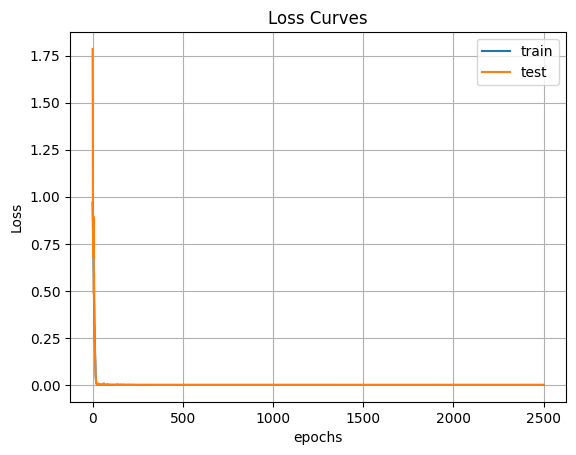

In [73]:
def plot_results(results: dict = results):
    """Plot the loss curves of a model"""
    epochs = list(range(len(results["train_loss"])))
    
    plt.plot(epochs, results["train_loss"], label="train")
    plt.plot(epochs, results["test_loss"], label="test")
    plt.title("Loss Curves")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plot_results()

In [74]:
# Some test points

test_points = [
    (200, 150, 25),    # Center (should be near 0)
    (0, 0, 0),         # Far corner
    (400, 300, 50),    # Opposite corner
    (150, 78, 100)  # Random point
]

print(f"{'x':>6} {'y':>6} {'z':>6} | {'Pred(scaled)':>14} {'Actual(scaled)':>16} | {'Pred(real)':>14} {'Actual(real)':>14}")
print("-" * 80)

for (x, y, z) in test_points:
    # Scale input
    inp = x_scaler.transform([[x, y, z]])
    inp_tensor = torch.tensor(inp, dtype=torch.float32).to(device)

    with torch.inference_mode():
        pred_scaled = model(inp_tensor).cpu().numpy()  # Model output (scaled)
        pred_real = y_scaler.inverse_transform(pred_scaled)  # Real units

    # Compute true values (both scaled + real)
    actual_real = -(((x-200)**2 + (y-150)**2 + (z-25)**2)) + 20 + random.randint(-10, 10)*0.01
    actual_scaled = y_scaler.transform([[actual_real]])[0, 0]

    print(f"{x:6d} {y:6d} {z:6d} | {pred_scaled[0,0]:14.5f} {actual_scaled:16.5f} | "
          f"{pred_real[0,0]:14.5f} {actual_real:14.5f}")

     x      y      z |   Pred(scaled)   Actual(scaled) |     Pred(real)   Actual(real)
--------------------------------------------------------------------------------
   200    150     25 |        1.19187          1.19070 |       31.95191       20.07000
     0      0      0 |       -4.86145         -5.03438 |   -61351.35938   -63104.92000
   400    300     50 |       -4.93359         -5.03438 |   -62082.93359   -63104.91000
   150     78    100 |       -0.12526         -0.12177 |   -13324.37207   -13288.96000


In [75]:
# Finding optimal parameters

# Starting prediction (random values)
x = np.array([[-1000.0, 5100.0, 3450.0]])

# Scale units
x_scaled = x_scaler.transform(x)

# Convert to tensor
x_tensor = torch.tensor(x_scaled, dtype=torch.float32, requires_grad=True, device=device)

optimizer = torch.optim.Adam([x_tensor], lr=0.1)
epochs = 201

for i in range(epochs):
    # 1. Forward pass
    pred_scaled = model(x_tensor)
    
    # 2. Calculate loss
    loss = -pred_scaled

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Keep scaled inputs within reasonable bounds
    with torch.no_grad():
        x_tensor.clamp_(-4, 4)
    
    pred_real = y_scaler.inverse_transform(pred_scaled.detach().cpu().numpy())

    if i % 20 == 0:
        print(f"Iter {i:3d} | Pred(real): {pred_real[0,0]:.3f}")

# Convert final scaled x back to REAL domain
x_best_scaled = x_tensor.detach().cpu().numpy()
x_best_real = x_scaler.inverse_transform(x_best_scaled)

y_best_scaled = model(x_tensor).detach().cpu().numpy()
y_best_real = y_scaler.inverse_transform(y_best_scaled)

print("\n===== OPTIMAL INPUTS (REAL UNITS) =====")
print("x:", x_best_real[0,0])
print("y:", x_best_real[0,1])
print("z:", x_best_real[0,2])
print("Predicted w (speed):", y_best_real[0,0])

Iter   0 | Pred(real): -2291191.250
Iter  20 | Pred(real): -52996.621
Iter  40 | Pred(real): -2324.789
Iter  60 | Pred(real): -373.455
Iter  80 | Pred(real): -31.549
Iter 100 | Pred(real): 24.487
Iter 120 | Pred(real): 31.331
Iter 140 | Pred(real): 31.801
Iter 160 | Pred(real): 31.944
Iter 180 | Pred(real): 31.958
Iter 200 | Pred(real): 31.958

===== OPTIMAL INPUTS (REAL UNITS) =====
x: 200.07951
y: 149.97514
z: 24.979
Predicted w (speed): 31.957773


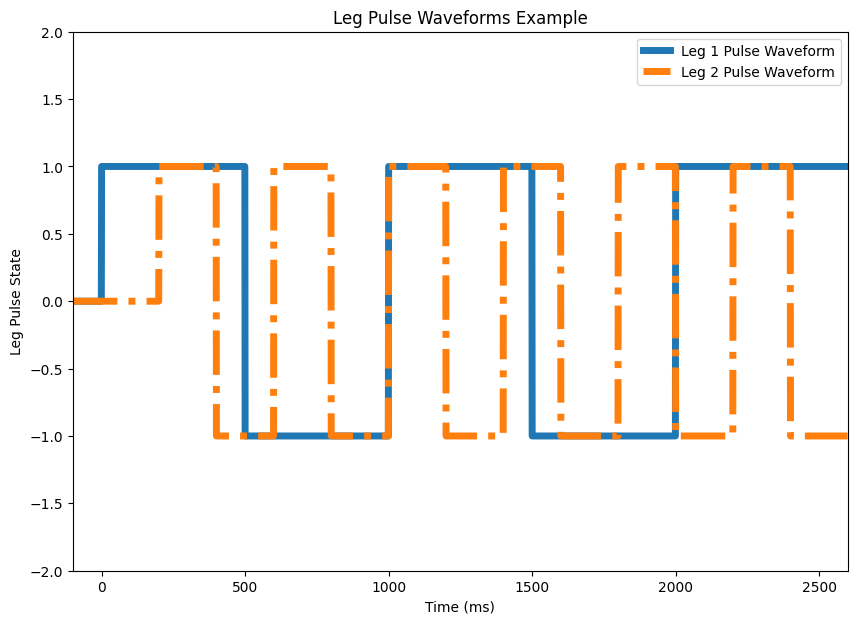

In [76]:
# Waveform example for paper
n = np.arange(-100, 2600)
u = lambda n: np.where(n >= 0, 1, 0)
x1 = u(n) - 2*u(n - 500) + 2*u(n - 1000) - 2*u(n - 1500) + 2*u(n - 2000)
x2 = u(n-200) - 2*u(n - 400) + 2*u(n - 600) - 2*u(n - 800) + 2*u(n - 1000) - 2*u(n - 1200) + 2*u(n - 1400) - 2*u(n - 1600) + 2*u(n - 1800) - 2*u(n - 2000) + 2*u(n - 2200) - 2*u(n - 2400)

plt.figure(figsize=(10, 7))
plt.plot(n, x1, label="Leg 1 Pulse Waveform", lw=5, ls="-")
plt.plot(n, x2, label="Leg 2 Pulse Waveform", lw=5, ls="-.")
plt.title("Leg Pulse Waveforms Example")
plt.xlabel("Time (ms)")
plt.ylabel("Leg Pulse State")
plt.xlim(-100, 2600)
plt.ylim(-2, 2)
plt.legend()